In [53]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from numpy import genfromtxt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso as SKLasso, Ridge as SKRidge
from numpy import ndarray
from enum import Enum

In [44]:

X = np.array([0, 1, 2, 3])
Y = np.array([[0], [1], [1], [2]])
w = np.array([[0], [0], [1]])
phi = np.array([X ** 2, X, np.ones(len(X))]).T
n = 4
step_size = 0.01
lam = 0.1

d_f = (2 / n) * phi.T.dot((phi.dot(w) - Y)) + np.sign(w)

w = w - step_size * d_f


In [47]:
error_list = []
for i in range(400):
    d_f = (2 / n) * phi.T.dot((phi.dot(w) - Y)) + lam * np.sign(w)
    w = w - step_size * d_f
    ŷ2 = phi.dot(w)
    e = (Y - ŷ2).T.dot((Y - ŷ2)) / n
    error_list.append(e.item())


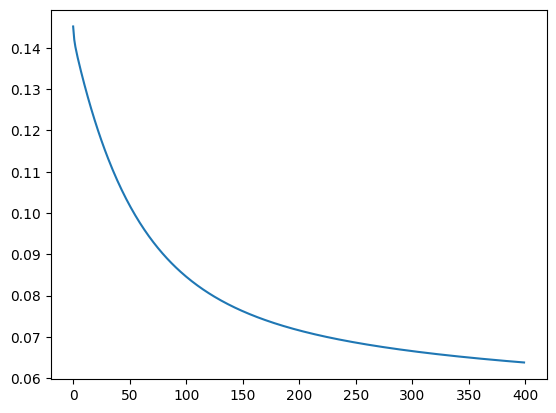

In [48]:
plt.plot(error_list)
plt.show()

In [60]:

X = genfromtxt('stock_prediction_data.csv', delimiter=',')
y = genfromtxt('stock_price.csv', delimiter=',')
y = y.reshape(-1, 1)

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_train)
X_val = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_val)
X_test = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_test)

def ߜLasso(w: ndarray, Φ: ndarray, y: ndarray, λ: float) -> ndarray:
    n, m = Φ.shape
    return 2/n * Φ.T.dot(Φ.dot(w) - y) + λ * np.sign(w) # if λ = 0, this is the gradient of the MSE loss function
def gradient_descent_lasso(Φ: ndarray, y: ndarray, α: float = 0.01, num_iter: int = 10_000, λ: float = 1) -> ndarray:
    n, m = Φ.shape
    w = np.zeros((m, 1))
    for _ in range(num_iter):
        gradient = ߜLasso(w, Φ, y, λ=λ)  # Gradient of Lasso Objective with respect to w
        # Checking for convergence
        if np.all(np.abs(gradient) < 1e-5) or np.isnan(gradient).any():
            break
        # Check for gradient explosion
        if np.isinf(gradient).any():
            raise ValueError("Gradient exploded")

        w -= α * gradient
    return w
def predict(Φ: ndarray, w: ndarray) -> ndarray:
    return Φ.dot(w)
def mse(y: ndarray, y_hat: ndarray) -> float:
    return np.mean((y - y_hat)**2)

w_lasso_gd = gradient_descent_lasso(X_train, y_train, λ=1)
pred_train = predict(X_train, w_lasso_gd)
print(f"My Lasso Regression Train MSE: {mse(y_train, pred_train)}")
pred_val = predict(X_val, w_lasso_gd)
print(f"My Lasso Regression Validation MSE: {mse(y_val, pred_val)}")

My Lasso Regression Train MSE: 2.1229748238302837
My Lasso Regression Validation MSE: 2.366520820219161


In [61]:
sk_poly_lasso = SKLasso(alpha=1)
sk_poly_lasso.fit(X_train,y_train.flatten()) # y is 2D, but scikit-learn expects 1D
pred_train = sk_poly_lasso.predict(X_train).reshape(-1,1)
print(f"SKLearn Lasso Train MSE: {mse(y_train, pred_train)}")
pred_val = sk_poly_lasso.predict(X_val).reshape(-1,1)
print(f"SKLearn Lasso Validation MSE: {mse(y_val, pred_val)}")

SKLearn Lasso Train MSE: 6.831045121140056
SKLearn Lasso Validation MSE: 7.629002980184826


In [62]:
valid_lambdas = [0, 0.1, 1, 10] # list of values to try for lambda
best_lambda_lasso = None # store the best lambda value
best_mse_lasso = float('inf') # store the best mse value
for λ in valid_lambdas:
    w_lasso_gd = gradient_descent_lasso(X_train, y_train, λ=λ) # train the model with Train data and λ
    pred_val = predict(X_val, w_lasso_gd) # predict the validation data
    mse_ = mse(y_val, pred_val)
    print(f"My Lasso Regression Validation MSE: {mse_} for lambda: {λ}")
    if mse_ < best_mse_lasso:
        best_mse_lasso = mse_
        best_lambda_lasso = λ
print(f"Best lambda: {best_lambda_lasso} with MSE: {best_mse_lasso}")

My Lasso Regression Validation MSE: 0.0929512768625821 for lambda: 0
My Lasso Regression Validation MSE: 0.09554581350427212 for lambda: 0.1
My Lasso Regression Validation MSE: 2.366520820219161 for lambda: 1
My Lasso Regression Validation MSE: 46.705761270943 for lambda: 10
Best lambda: 0 with MSE: 0.0929512768625821
